In [1]:
import gym
import numpy as np
import math

import os

import matplotlib.pyplot as plt

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy

# CartPole Environment

In [2]:
name = "CartPole-v0"
env = gym.make(name)
spec = gym.spec(name)

print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Max Episode Steps: {spec.max_episode_steps}")
print(f"Nondeterministic: {spec.nondeterministic}")
print(f"Reward Range: {env.reward_range}")
print(f"Reward Threshold: {spec.reward_threshold}")

Action Space: Discrete(2)
Observation Space: Box(4,)
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 195.0


/home/pf/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Helper Functions

In [3]:
def evaluate(model, num_episodes=20):
    """
    Evaluate a RL agent
    :param model: the RL Agent
    :param num_episodes: number of episodes to evaluate it
    :return: Mean reward for the last num_episodes
    """
    all_episode_rewards = np.zeros((num_episodes))
    env = gym.make(name)
    env.seed(42)

    for i in range(num_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done:
            action, _ = model.predict(obs)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards[i] = sum(episode_rewards)
    
    env.close()

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward

# Q-Learning

In [4]:
class QLearningContinuous :
    def __init__(self, env, gamma=0.7,
                 epsilon=1.0, buckets=(1, 1, 6, 12,)):
        """
        :param env: OpenAI RL environment to solve
        :param gamma: Decay factor
        :param epsilon: Exploration term
        :param buckets: DImension of the discretinsed observation
        """
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.buckets = buckets
        self.Q = np.zeros(buckets + (self.env.action_space.n,))
        np.random.seed(0)

    def _continuous_to_discrete(self, obs):
        """
        Convert the continuous state into a discrete array.
        :param obs: Environment state
        """
        # https://gist.github.com/n1try/af0b8476ae4106ec098fea1dfe57f578
        upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50)]
        lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50)]
        ratios = [(obs[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(obs))]
        new_obs = [int(round((self.buckets[i] - 1) * ratios[i])) for i in range(len(obs))]
        new_obs = [min(self.buckets[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
        return tuple(new_obs)

    def _bellman_equation(self, state, action, reward, next_state):
        """
        Update the Q-Learning table with discounted reward
        :param state: Current state of the environment.
        :param action: Action to be taken by the agent.
        :param reward: Reward perceived by the agent.
        :param next_state: Current state of the environment.
        """
        state = self._continuous_to_discrete(state)
        next_state = self._continuous_to_discrete(next_state)
        self.Q[state][action] = self.Q[state][action] + self.gamma * (reward + np.max(self.Q[next_state]) - self.Q[state][action])

    def _epsilon_decay(self, total_time):
        """
        Decay the exploration factor in training.
        :param total_time: max number of steps to play
        :return: new exploration factor
        """
        exploration_steps = total_time / 2
        epsilon_decay = (1 - 0.1) / exploration_steps
        return max(self.epsilon - epsilon_decay, 0.1)


    def predict(self, obs):
        """
        Q-Learning table lookup for decision making.
        :param obs: Current observation of the agent
        :return: Action the agent will make.
        """
        if np.random.uniform(0, 1) < self.epsilon:
            # Select a random action at random occurrences
            return self.env.action_space.sample(), {}
        # Select optimal action
        obs = self._continuous_to_discrete(obs)
        return np.argmax(self.Q[obs]), {}

    def learn(self, total_timesteps, verbose=1):
        """ 
        Q-Learning updating through game-playing
        :param total_timesteps: Max number of steps to play
        """
        rewards = []
        timesteps = 0

        for episode in range(total_timesteps):
            # Reset variables for new game
            state = self.env.reset()
            done = False
            cum_reward = 0

            # Repeat until game-over
            while not done and cum_reward <= 200:
                # Predict new decision
                action, _ = self.predict(state)
                # Simulate decision
                next_state, reward, done, info = self.env.step(action)
                # Update Q table
                self._bellman_equation(state, action, reward, next_state)
                # Track the run
                state = next_state
                cum_reward += 1
                timesteps += 1 
                # Decay exploration
                self.epsilon = self._epsilon_decay(total_timesteps)
                # self.epsilon = self._epsilon_decay(timesteps, total_timesteps)

            rewards.append(cum_reward)

            if cum_reward > 195 and verbose:
                print('Solved at episode {} - after {} frames.'.format(episode, timesteps))

            if not episode % 100 and verbose:
                print('Episode {} - Mean survival time was {} frames.'.format(episode, np.mean(rewards)))
                rewards = []

            if timesteps > total_timesteps:
                return None

## Random Agent

In [5]:
env = gym.make(name)
env.seed(42)

model = QLearningContinuous(env)

_ = evaluate(model)

Mean reward: 24.0 Num episodes: 20


## Agent Training

In [7]:
# Create log dir
log_dir = f"logs/{name}/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make(name)

# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)
env.seed(42)

model = QLearningContinuous(env)

/home/pf/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [8]:
total_steps = 2e5
model.learn(total_timesteps=int(total_steps), verbose=0)

## Evaluation

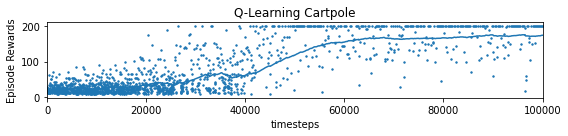

In [9]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], 2*total_steps, results_plotter.X_TIMESTEPS, "Q-Learning Cartpole")

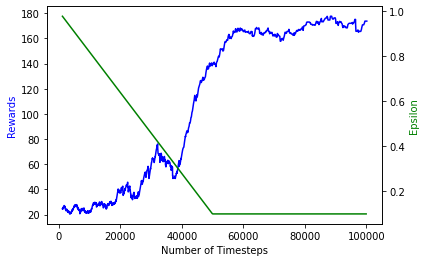

In [10]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y1 = ts2xy(load_results(log_folder), 'timesteps')
    y1 = moving_average(y1, window=50)
    # Truncate x
    x = x[len(x) - len(y1):]

    # Exploration epsilon values
    exploration_steps = total_steps / 2
    epsilon_decay = (1 - 0.1) / exploration_steps
    y2 = np.array([max(1 - epsilon_decay * time, 0.1) for time in range(int(total_steps))])[x[x < total_steps]]
    
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(x, y1, 'b-')
    ax2.plot(x[x < total_steps], y2, 'g-')

    ax1.set_xlabel('Number of Timesteps')
    ax1.set_ylabel('Rewards', color='b')
    ax2.set_ylabel('Epsilon', color='g')

    plt.show()

plot_results(log_dir)

In [11]:
_ = evaluate(model)

Mean reward: 100.3 Num episodes: 20


/home/pf/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [12]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

video_folder = log_dir + 'video'
video_length = 100

env = DummyVecEnv([lambda: gym.make(name)])

obs = env.reset()

# Record the video starting at the first step
env = VecVideoRecorder(env, video_folder,
                       record_video_trigger=lambda x: x == 0,
                       video_length=video_length,
                       name_prefix="QL-{}".format(name))

obs = env.reset()
for _ in range(video_length + 1):
    action, _ = model.predict(obs[0]) # Get the observation in the Vectorized environments
    obs, _, done, _ = env.step([action])
    if done:
        break
    
# Save the video
env.close()

Saving video to /home/pf/Documents/rl/logs/CartPole-v0/video/QL-CartPole-v0-step-0-to-step-100.mp4


In [13]:
from IPython.display import Video

Video(video_folder + f"/QL-{name}-step-0-to-step-100.mp4")